# **Load Libraries**

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import random
import re
from collections import defaultdict
import wordcloud
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import warnings
# warnings.filterwarnings("ignore")
# import keras,os
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, LSTM, CuDNNLSTM, Embedding, Dropout
# #from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.optimizers import Adam

# **EDA**

In [94]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   text2     7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


In [22]:
train_data['target'].value_counts().to_frame()

,target
0,4342
1,3271


<AxesSubplot:title={'center':'Target Distribution'}, xlabel='target'>

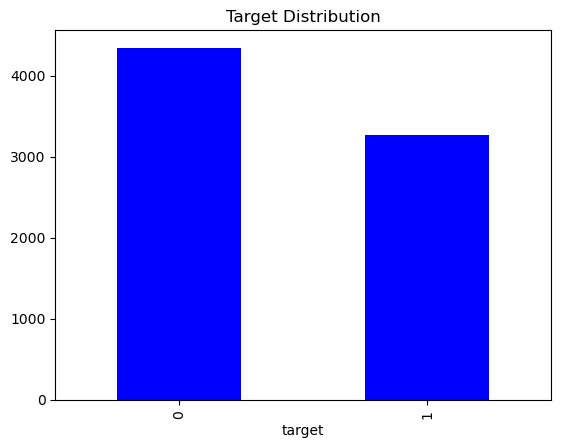

In [23]:
train_data.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target Distribution')

Text(0.5, 0.98, 'Words in a tweet')

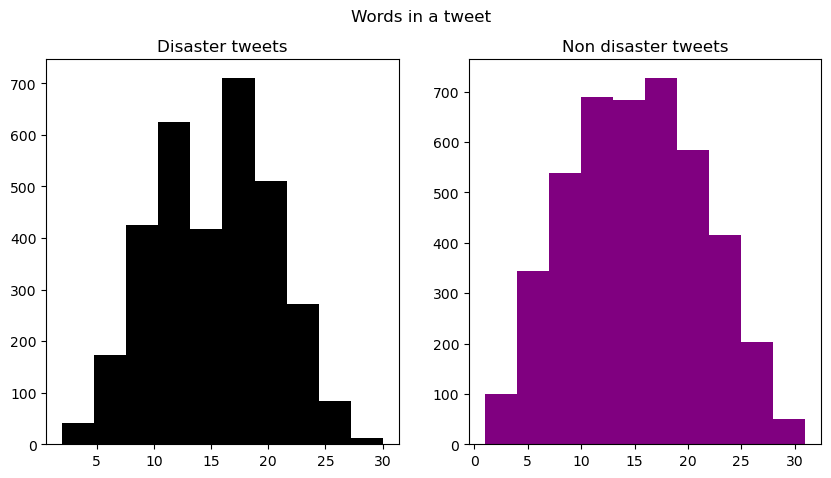

In [54]:
#Number of words in a tweet
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='black')
ax1.set_title('Disaster tweets')
tweet_len = train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

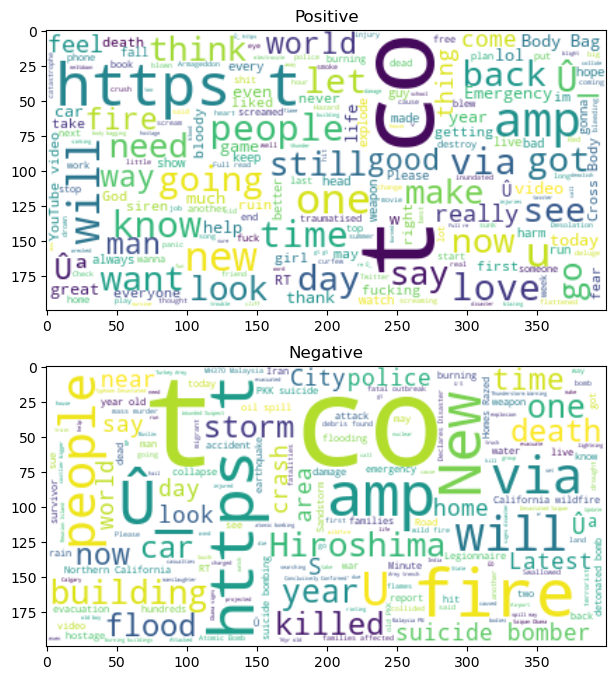

In [29]:
positive_cases = "".join(train_data[train_data['target'] == 0]['text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

plt.show()

In [95]:
seed = 777
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
print('done')

done


In [96]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

#def strip_all_entities(x):
#    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [97]:
train_data['clean_text'] = train_data['text'].apply(lambda x: x.lower())
#train_data['text2'] = train_data['text2'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
train_data['clean_text'] = train_data['clean_text'].apply(remove_less_than)
train_data['clean_text'] = train_data['clean_text'].apply(remove_non_alphabet)
train_data['clean_text'] = train_data['clean_text'].apply(remove_stopwords)
train_data['clean_text'] = train_data['clean_text'].apply(remove_punctuation)
#train_data['text2'] = train_data['text2'].apply(spell_check)
print('done')

done


In [98]:
train_data.head(5)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked notified evacuation shelter pl...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,sent photo ruby smoke pours school


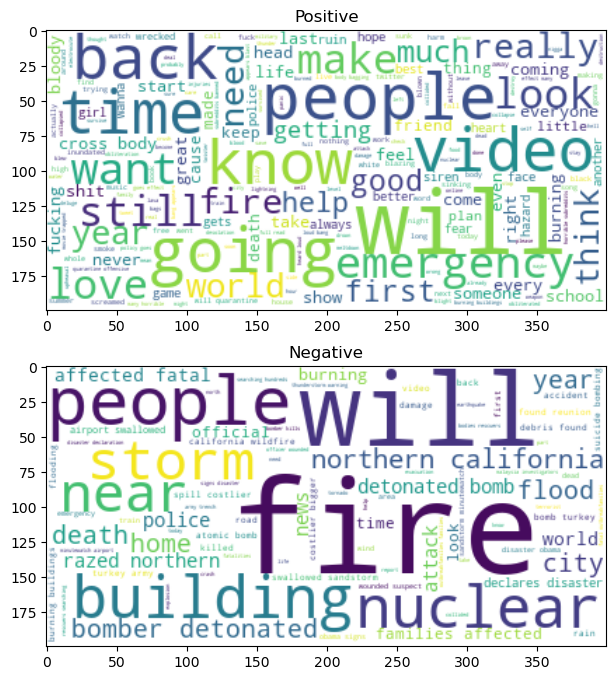

In [99]:
positive_cases = "".join(train_data[train_data['target'] == 0]['clean_text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['clean_text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

plt.show()

# **Build Model**

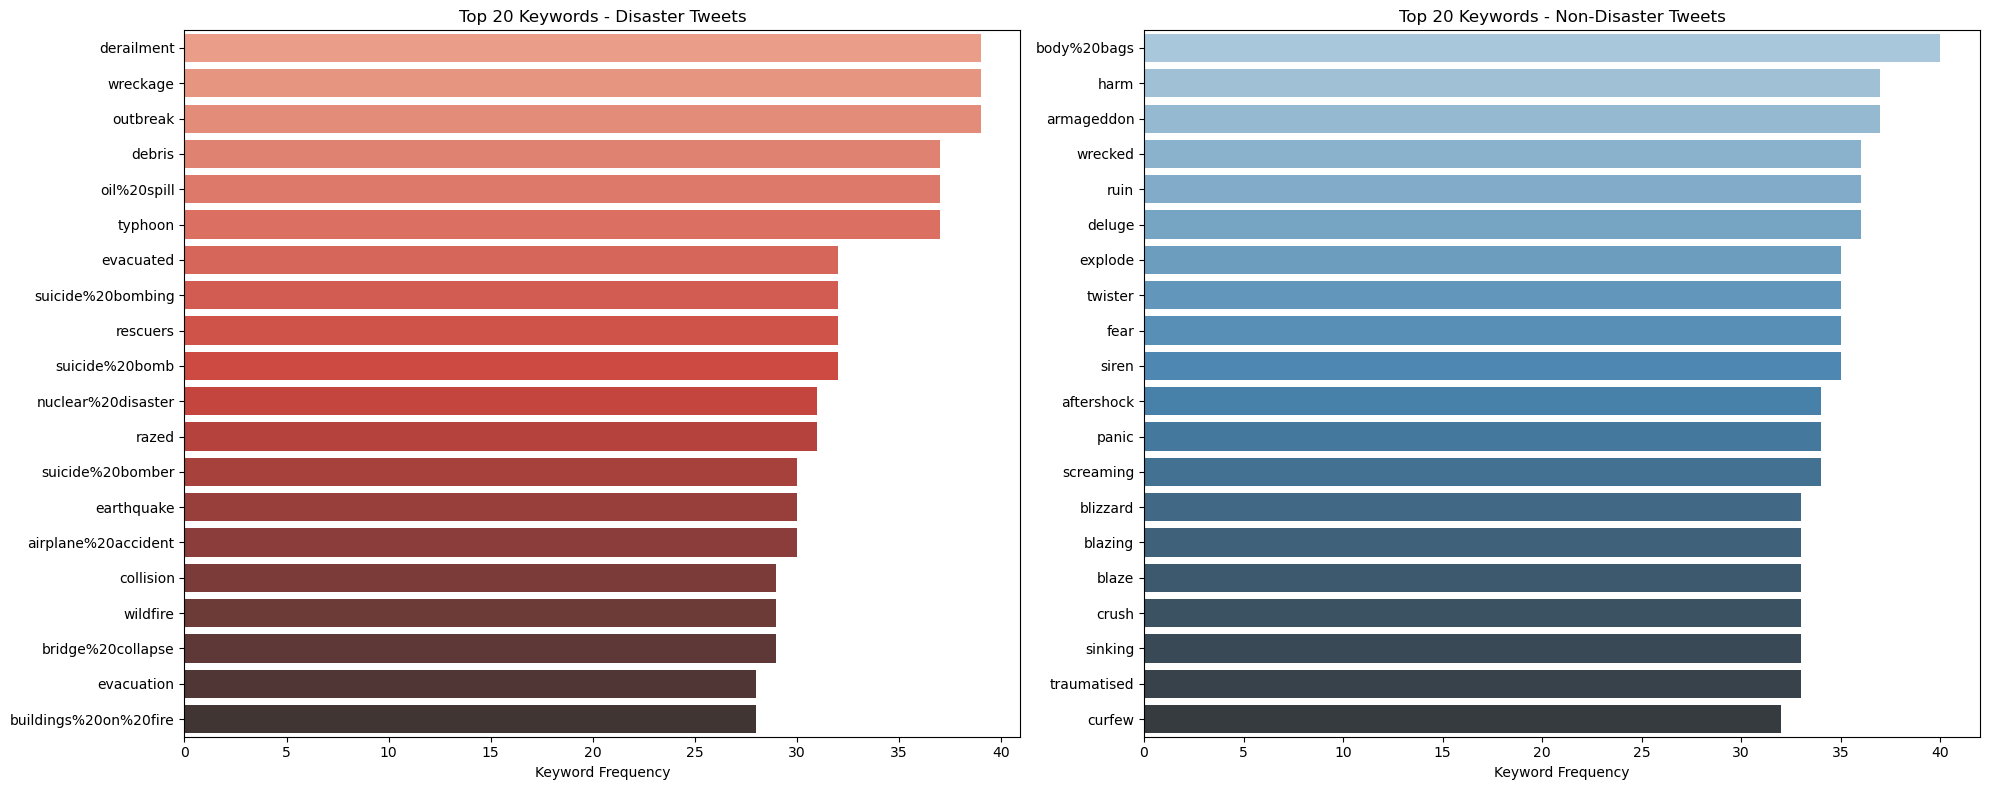

In [100]:
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

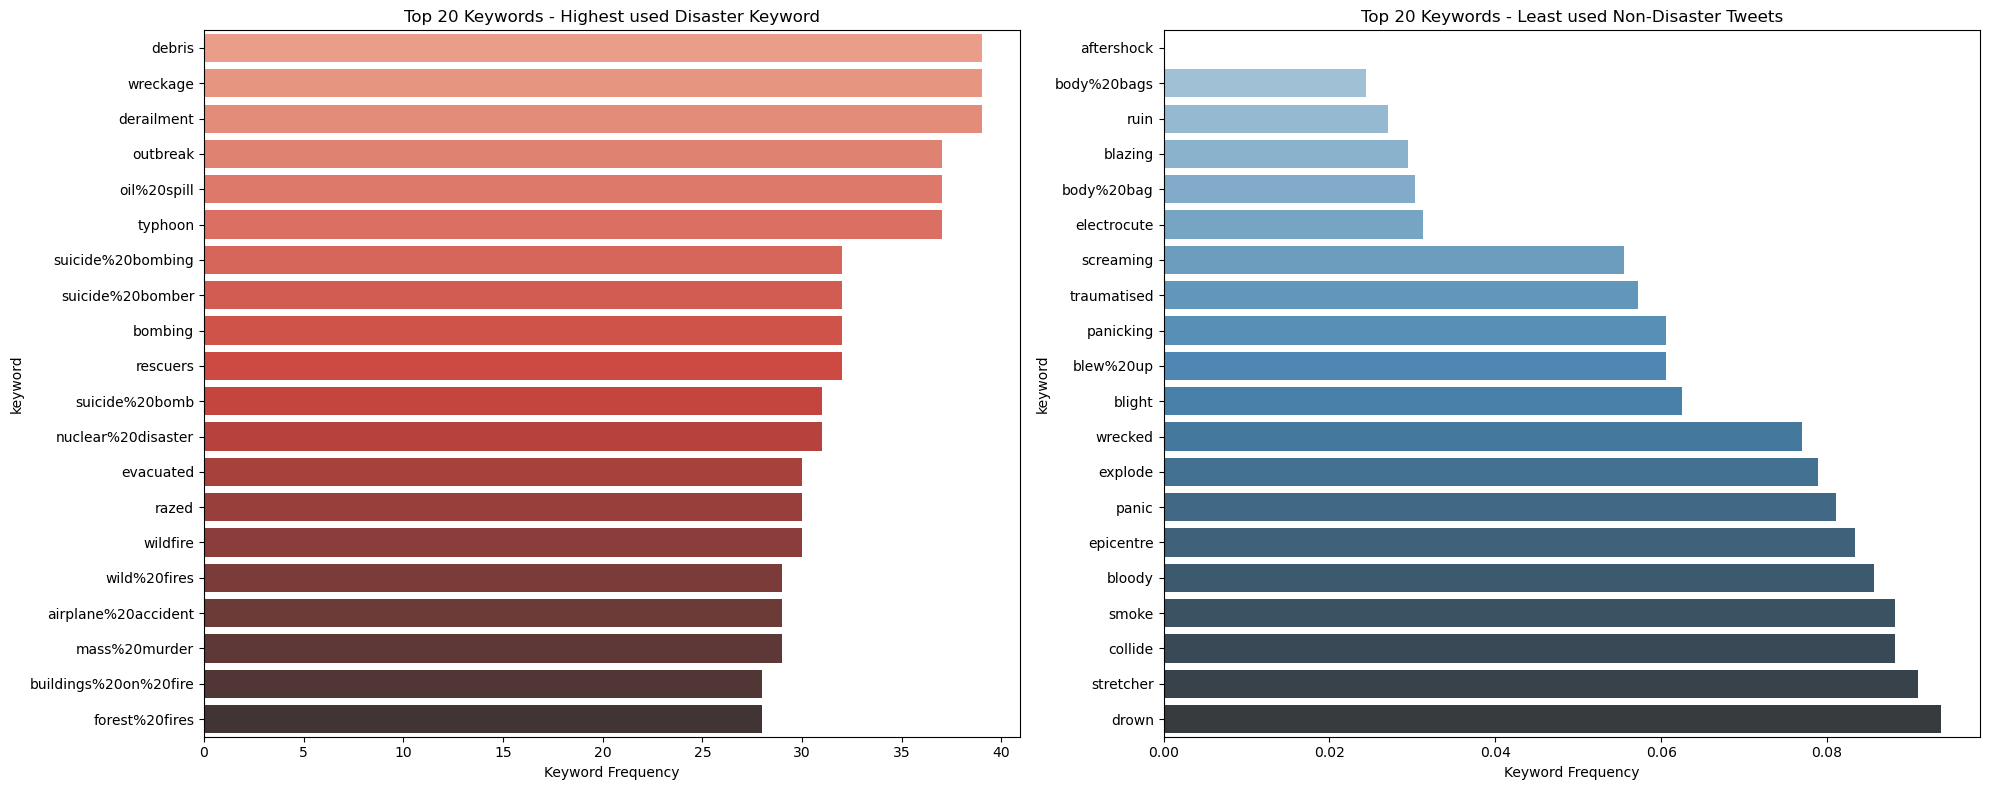

In [76]:
top_disaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values(ascending = False).head(20)
top_nondisaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values().head(20)

fig, ax = plt.subplots(1,2, figsize=(20,8))

sns.barplot(y=top_disaster_keyword[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Highest used Disaster Keyword")
ax[0].set_xlabel("Keyword Frequency")


sns.barplot(y=top_nondisaster_keyword[0:20].index, x=top_nondisaster_keyword[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Least used Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

In [105]:
locations = train_data["location"].value_counts()

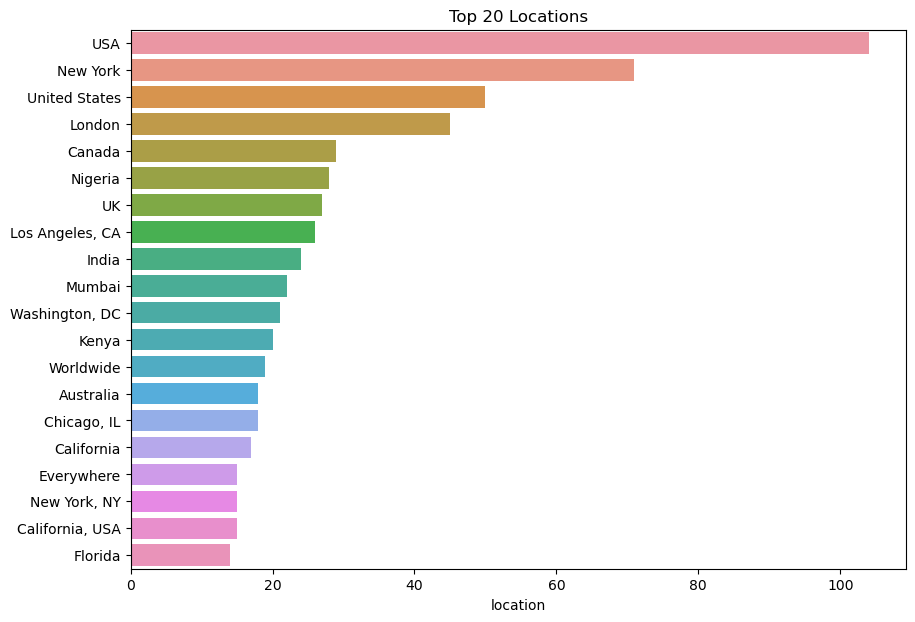

In [106]:
plt.figure(figsize=(10,7))
sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')
plt.title("Top 20 Locations")
plt.show()

In [107]:
print(len(train_data['text']))

7613


In [108]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,clean_text,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge canada,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked notified evacuation shelter pl...,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,sent photo ruby smoke pours school,88


In [109]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

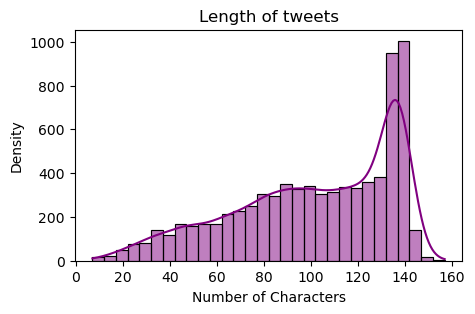

In [83]:
plt.figure(figsize=(5,3))
sns.histplot(train_data["length"], kde=True,color='purple',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

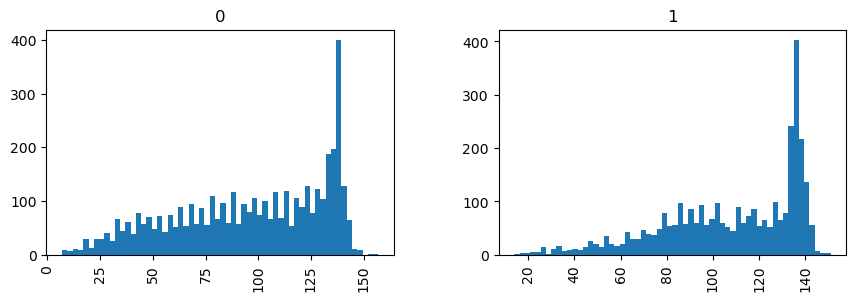

In [84]:
train_data.hist(column='length', by = 'target',bins =60, figsize= (10,3))

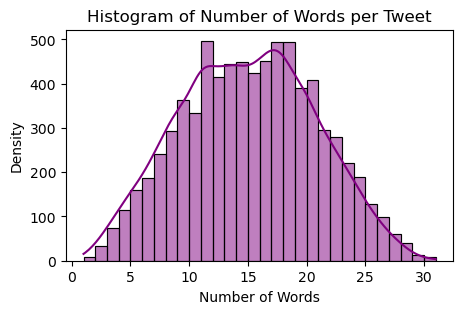

In [85]:
def count_words(x):
    return len(x.split())

train_data["num_words"] = train_data["text"].apply(count_words)

plt.figure(figsize=(5,3))
sns.histplot(train_data["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

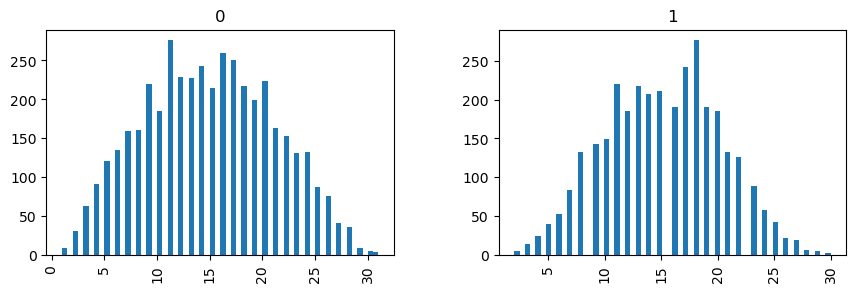

In [86]:
train_data.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

In [112]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)
X.shape

(7613, 16)

In [117]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)

In [118]:
#XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
# reference: https://www.tensorflow.org/xla
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [119]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 7s 19ms/step - loss: 0.5684 - accuracy: 0.7095 - val_loss: 0.4527 - val_accuracy: 0.7925
Epoch 2/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3999 - accuracy: 0.8259 - val_loss: 0.4511 - val_accuracy: 0.8050
Epoch 3/10
191/191 [==============================] - 3s 17ms/step - loss: 0.3419 - accuracy: 0.8529 - val_loss: 0.5081 - val_accuracy: 0.7748
Epoch 4/10
191/191 [==============================] - 3s 18ms/step - loss: 0.3091 - accuracy: 0.8719 - val_loss: 0.5078 - val_accuracy: 0.7879
Epoch 5/10
191/191 [==============================] - 4s 18ms/step - loss: 0.2784 - accuracy: 0.8831 - val_loss: 0.5672 - val_accuracy: 0.7708
Epoch 6/10
191/191 [==============================] - 3s 17ms/step - loss: 0.2572 - accuracy: 0.8921 - val_loss: 0.6106 - val_accuracy: 0.7603
Epoch 7/10
191/191 [==============================] - 4s 19ms/step - loss: 0.2310 - accuracy: 0.9039 - val_loss: 0.6678 - val_accuracy: 0.7485

In [121]:
y_pred = model.predict(X_test).round()
y_pred

48/48 [==============================] - 0s 4ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [122]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

191/191 [==============================] - 1s 3ms/step


94

In [123]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7550886408404465
Recall  is    :  0.7332317073170732
Precision  is :  0.7083946980854198


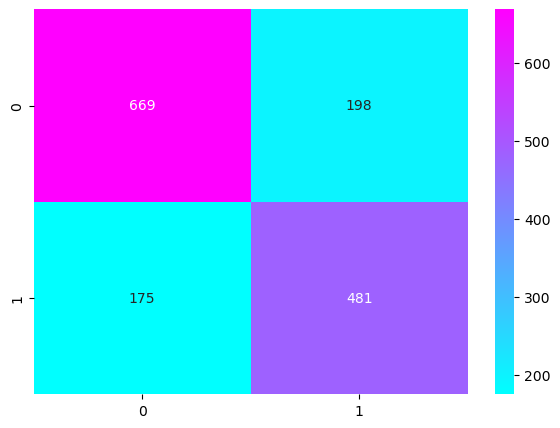

In [124]:
conm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       867
           1       0.71      0.73      0.72       656

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [126]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
test_data.head().style.background_gradient(cmap='coolwarm')

In [128]:
test_data['clean_text'] = test_data['text'].apply(lambda x: x.lower())
test_data['clean_text'] = test_data['clean_text'].apply(remove_less_than)
test_data['clean_text'] = test_data['clean_text'].apply(remove_non_alphabet)
test_data['clean_text'] = test_data['clean_text'].apply(remove_stopwords)
test_data['clean_text'] = test_data['clean_text'].apply(remove_punctuation)
print('done')

done


In [129]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X, maxlen =l)

In [132]:
tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [133]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [136]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 36s 153ms/step - loss: 0.5491 - accuracy: 0.7223 - val_loss: 0.5186 - val_accuracy: 0.7466
Epoch 2/10
191/191 [==============================] - 28s 147ms/step - loss: 0.3729 - accuracy: 0.8358 - val_loss: 0.5383 - val_accuracy: 0.7367
Epoch 3/10
191/191 [==============================] - 28s 148ms/step - loss: 0.3027 - accuracy: 0.8732 - val_loss: 0.6122 - val_accuracy: 0.7262
Epoch 4/10
191/191 [==============================] - 28s 146ms/step - loss: 0.2558 - accuracy: 0.8941 - val_loss: 0.6918 - val_accuracy: 0.7190


In [137]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

102/102 [==============================] - 3s 23ms/step


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.337420
std,3146.427221,0.472902
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


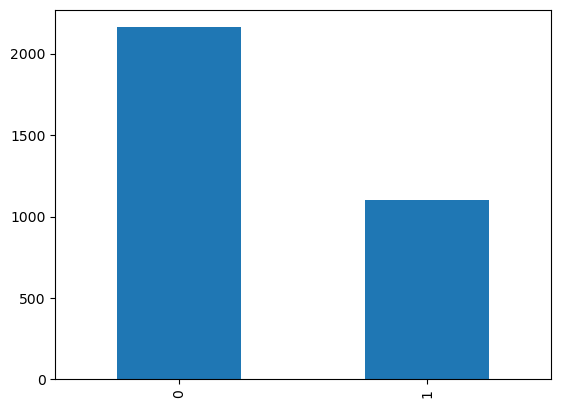

In [138]:
submission.target.value_counts().plot.bar();